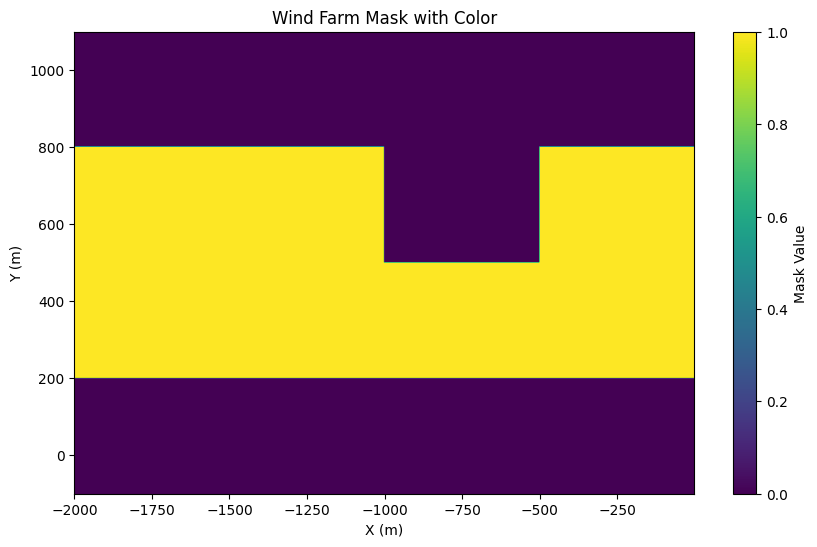

In [126]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

def create_wind_farm_mask(corner_points, resolution=10, rotation_degrees=0, mirror_axis=None):
    points = np.array(corner_points)

    # Apply mirroring
    if mirror_axis:
        if 'x' in mirror_axis:
            points[:, 0] = -points[:, 0]
        if 'y' in mirror_axis:
            points[:, 1] = -points[:, 1]

    # Apply rotation
    if rotation_degrees != 0:
        centroid = points.mean(axis=0)
        translated_points = points - centroid
        theta = np.radians(rotation_degrees)
        rotation_matrix = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])
        points = np.dot(translated_points, rotation_matrix.T) + centroid

    # Align downstream edge to x = 0
    max_x = points[:, 0].max()
    points[:, 0] -= max_x

    # Determine bounds
    min_x, min_y = points.min(axis=0)
    max_x, max_y = points.max(axis=0)

    # Define resolution factors
    fine_resolution = resolution / 5
    buffer_height = 100  # height above and below with higher res

    # Build y_range with variable resolution
    y_highres_bottom = np.arange(min_y - buffer_height, min_y, fine_resolution)
    y_normal = np.arange(min_y, max_y, resolution)
    y_highres_top = np.arange(max_y, max_y + buffer_height, fine_resolution)
    y_range = np.concatenate([y_highres_bottom, y_normal, y_highres_top])

    # x_range stays consistent
    x_range = np.arange(min_x, max_x, resolution)

    # Build grid
    grid_x, grid_y = np.meshgrid(x_range, y_range)
    grid_points = np.vstack((grid_x.ravel(), grid_y.ravel())).T

    # Create polygon path and mask
    polygon_path = Path(points)
    mask = polygon_path.contains_points(grid_points)
    mask_2d = mask.reshape(grid_x.shape)

    return mask_2d.astype(int), x_range, y_range


# Example usage
corner_points = [(0, 0), (200, 0), (200, 100), (100, 100), (100, 50), (50, 50), (50, 100), (0, 100)]
corner_points = [(x * 10, y * 10) for x, y in corner_points]
rotation_degrees = 0  # Rotate by 180 degrees
mirror_axis = 'x'  # Mirror along the x-axis
mask_2d, x_range, y_range = create_wind_farm_mask(corner_points, resolution=1, rotation_degrees=rotation_degrees, mirror_axis = 'x'
)

plt.figure(figsize=(10, 6))
extent = [x_range[0], x_range[-1], y_range[0], y_range[-1]]
plt.imshow(mask_2d, origin='lower', extent=extent, cmap='viridis', aspect='auto')
plt.colorbar(label='Mask Value')
plt.title("Wind Farm Mask with Color")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.show()

In [127]:
# Constants
D = 100
s_x = 10
s_y = 10
C_T = 0.8
U_G = 11.87
z_h = 100
C_star = 4.5
f = 1e-4
k = 0.4
z_0lo = 0.0001

# Nygaard setup
ct = (np.pi * C_T * D**2) / (8 * s_x * D * s_y * D)
nu_star = 28 * np.sqrt(ct)
beta = nu_star / (1 + nu_star)
z_0hi = z_h * (1 + D/(2*z_h))**beta * np.exp(-(ct / (2*k**2) + (np.log(z_h / z_0lo * (1 - D/(2*z_h))**beta))**-2)**-0.5)
u_star_lo = (k * U_G) / (np.log(U_G / (f * z_0lo)) - C_star)
U_h0 = u_star_lo / k * np.log(z_h / z_0lo)
z0_WF = z_h * (1 + D/(2*z_h))**beta * np.exp(-k * (ct + (k / np.log((z_h / z_0lo) * (1 - D/(2*z_h))**beta))**2)**-0.5)

In [128]:
# Compute upstream, downstream, and effective lengths per y-section
effective_lengths = []
upstream_xs = []
downstream_xs = []

for row_index in range(mask_2d.shape[0]):
    row_mask = mask_2d[row_index]
    true_indices = np.where(row_mask)[0]

    if true_indices.size > 0:
        # Convert mask indices to x-values
        upstream_x = x_range[true_indices[0]]
        downstream_x = x_range[true_indices[-1]]
        effective_length = downstream_x - upstream_x

        upstream_xs.append(upstream_x)
        downstream_xs.append(downstream_x)
        effective_lengths.append(effective_length)
    else:
        # If no part of wind farm is in this y-slice
        upstream_xs.append(None)
        downstream_xs.append(None)
        effective_lengths.append(0)

# Convert to numpy arrays for easy handling
upstream_xs = np.array(upstream_xs, dtype=float)
downstream_xs = np.array(downstream_xs, dtype=float)
effective_lengths = np.array(effective_lengths)

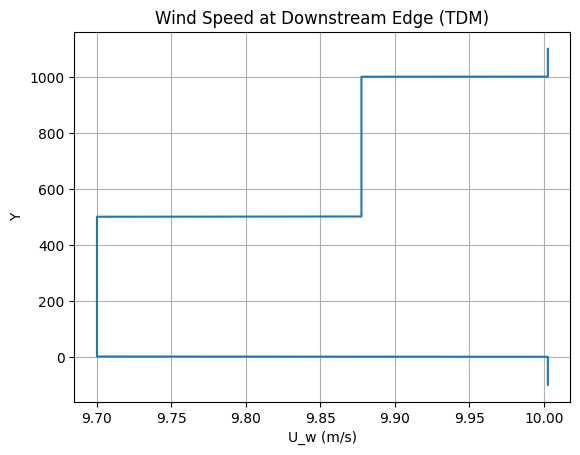

In [129]:
def safe_velocity(U_h0, h1, h2, z_0lo, z0_WF, z_h):
    """
    Returns the velocity using the log formula, but always capped at U_h0.
    """
    h1 = max(h1, z_h)
    h2 = max(h2, z_h)
    uw = U_h0 * (np.log(h1 / z_0lo) * np.log(h2 / z0_WF)) / \
                (np.log(h1 / z0_WF) * np.log(h2 / z_0lo))
    return min(U_h0, uw)

def compute_tdm_velocity_at_downstream_edge_multi_zone(
    mask_2d, x_range, y_range,
    U_h0, z_h, z0_WF, z_0lo,
    x_target
):
    uw_result = []

    for y_idx, mask_row in enumerate(mask_2d):
        true_indices = np.where(mask_row)[0]
        if true_indices.size == 0:
            uw_result.append(U_h0)
            continue

        # Detect all deficit segments
        diffs = np.diff(true_indices)
        breaks = np.where(diffs > 1)[0]
        start_indices = [true_indices[0]] + [true_indices[i + 1] for i in breaks]
        end_indices = [true_indices[i] for i in breaks] + [true_indices[-1]]
        segments = [(x_range[start], x_range[end]) for start, end in zip(start_indices, end_indices)]

        uw = U_h0
        active_segment = None
        in_recovery = False

        for x1, x2 in segments:
            if x1 <= x_target <= x2:
                # Inside deficit segment
                h1 = z_h + ((x_target - x1) / z0_WF)**(4/5)
                if h1 >= z_h:
                    uw = safe_velocity(U_h0, h1, z_h, z_0lo, z0_WF, z_h)
                    in_recovery = False
                else:
                    # Extend recovery until h1 is valid
                    if active_segment:
                        x1_ref = active_segment[0]
                        x2_last = active_segment[1]
                        h1_r = z_h + ((x_target - x1_ref) / z0_WF)**(4/5)
                        h2_r = ((x_target - x2_last) / z0_WF)**(4/5)
                        uw = safe_velocity(U_h0, h1_r, h2_r, z_0lo, z0_WF, z_h)
                        in_recovery = True
                active_segment = (x1, x2)
                break
            elif x_target > x2:
                active_segment = (x1, x2)

        # If not in recovery, apply post-deficit recovery if x_target is beyond last segment
        if not in_recovery and active_segment and x_target > active_segment[1]:
            x1_ref = active_segment[0]
            x2_last = active_segment[1]
            h1 = z_h + ((x_target - x1_ref) / z0_WF)**(4/5)
            h2 = ((x_target - x2_last) / z0_WF)**(4/5)
            uw = safe_velocity(U_h0, h1, h2, z_0lo, z0_WF, z_h)

        uw_result.append(uw)

    return np.array(uw_result)


x_target = 2000  # some downstream location beyond the park
uw_at_target = compute_tdm_velocity_at_downstream_edge_multi_zone(
    mask_2d, x_range, y_range,
    U_h0, z_h, z0_WF, z_0lo,
    x_target=x_target
)

# Plot result with switched axes
plt.figure()
plt.plot(uw_at_target, y_range)
plt.title("Wind Speed at Downstream Edge (TDM)")
plt.ylabel("Y")
plt.xlabel("U_w (m/s)")
plt.grid(True)
plt.show()

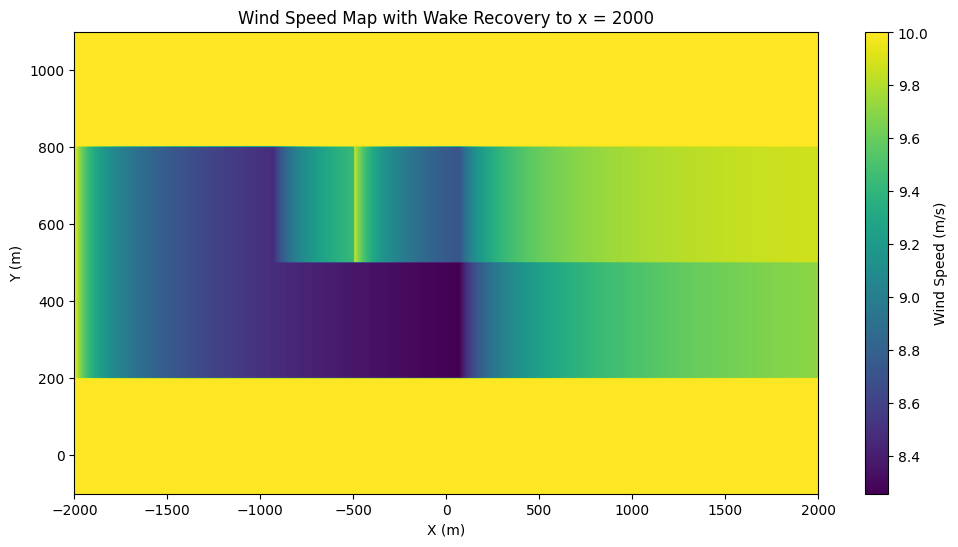

In [130]:
def compute_multiple_deficit_zones(mask_2d, x_range):
    x_segments_per_row = []

    for row in mask_2d:
        true_indices = np.where(row)[0]
        segments = []

        if true_indices.size > 0:
            diffs = np.diff(true_indices)
            breaks = np.where(diffs > 1)[0]
            start_indices = [true_indices[0]] + [true_indices[i + 1] for i in breaks]
            end_indices = [true_indices[i] for i in breaks] + [true_indices[-1]]
            for start, end in zip(start_indices, end_indices):
                x1 = x_range[start]
                x2 = x_range[end]
                segments.append((x1, x2))
        x_segments_per_row.append(segments)

    return x_segments_per_row


# Create extended x-range
extended_x_range = np.arange(x_range[0], x_target + 10, 10)
wind_speed_map = np.full((len(y_range), len(extended_x_range)), U_h0)

# Detect wake segments
x_segments_per_row = compute_multiple_deficit_zones(mask_2d, x_range)

U_h0_local = U_h0  # Start with global value
max_recovery_uw = U_h0  # Track the max wind speed in the recovery zone

for y_idx, segments in enumerate(x_segments_per_row):
    active_segment = None
    in_recovery = False

    for x_idx, x_val in enumerate(extended_x_range):
        applied = False

        # 1. Check if inside any deficit segment
        for (x1, x2) in segments:
            if x1 <= x_val <= x2:
                # If new deficit segment, update U_h0_local
                if active_segment != (x1, x2):
                    U_h0_local = max_recovery_uw  # Use recovery max
                    active_segment = (x1, x2)
                    in_recovery = False

                h1 = z_h + ((x_val - x1) / z0_WF)**(4/5)
                if h1 >= z_h:
                    uw = U_h0_local * (np.log(h1 / z_0lo) * np.log(z_h / z0_WF)) / \
                                      (np.log(h1 / z0_WF) * np.log(z_h / z_0lo))
                    wind_speed_map[y_idx, x_idx] = uw
                    applied = True
                break

        # 2. If in recovery zone after a deficit
        if not applied and active_segment and x_val > active_segment[1]:
            x1_ref, x2_last = active_segment

            h1 = z_h + ((x_val - x1_ref) / z0_WF)**(4/5)
            h2 = ((x_val - x2_last) / z0_WF)**(4/5)

            if h1 >= z_h and h2 >= z_h:
                uw = U_h0_local * (np.log(h1 / z_0lo) * np.log(h2 / z0_WF)) / \
                                   (np.log(h1 / z0_WF) * np.log(h2 / z_0lo))
            elif h1 >= z_h:
                uw = U_h0_local * (np.log(h1 / z_0lo) * np.log(z_h / z0_WF)) / \
                                   (np.log(h1 / z0_WF) * np.log(z_h / z_0lo))
            else:
                uw = wind_speed_map[y_idx, x_idx - 1]  # keep previous

            wind_speed_map[y_idx, x_idx] = uw
            in_recovery = True
            max_recovery_uw = max(max_recovery_uw, uw)  # update max for next deficit
            applied = True

        # 3. Fallback (freestream or continue recovery)
        if not applied:
            if x_idx > 0:
                uw = wind_speed_map[y_idx, x_idx - 1]
            else:
                uw = U_h0

            wind_speed_map[y_idx, x_idx] = uw
            if in_recovery:
                max_recovery_uw = max(max_recovery_uw, uw)


plt.figure(figsize=(12, 6))
extent = [extended_x_range[0], extended_x_range[-1], y_range[0], y_range[-1]]
plt.imshow(wind_speed_map, origin='lower', extent=extent, aspect='auto', cmap='viridis')
plt.colorbar(label='Wind Speed (m/s)')
plt.title(f"Wind Speed Map with Wake Recovery to x = {x_target}")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.show()